In [1]:
import sklearn
import pywt
import numpy
import os
import pandas
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, metrics, tree

In [12]:
def haar_wavelet(img, counter = 3):
    if (counter == 0):
        return img.flatten()
    LL, (LH_, HL_, HH_) = pywt.dwt2(img, 'haar') # LL corresponds to the top left quad of the picture 
    return haar_wavelet(LL, counter - 1)

In [7]:
images_folder = "./CK+48/"

haar_iterations = 3
number_of_columns = {2: 144, 3: 36, 4: 9}

column_names = [i for i in range(0, number_of_columns[haar_iterations])]
image_coeffs = []
emotions = []

for dirname, dirs, files in os.walk(images_folder):
    for filename in files:
        image_to_read = numpy.asarray(Image.open(dirname + "/" + filename))
        coeffs = haar_wavelet(image_to_read, haar_iterations)
        image_coeffs.append(coeffs)
        emotions.append(dirname.rsplit("/",1)[-1])

image_coeffs = numpy.array(image_coeffs)
print(image_coeffs)
images_df = pandas.DataFrame(image_coeffs, columns=column_names)
images_df["emotion"] = emotions

print(len(image_coeffs[0]))


[[ 113.625  209.875 1028.5   ...  417.375  492.75  1014.375]
 [ 109.     215.    1034.375 ...  438.75   492.875  945.5  ]
 [ 104.625  186.25  1005.75  ...  397.625  475.625 1014.625]
 ...
 [  47.     514.    1692.875 ...  774.875 1371.5    582.5  ]
 [  41.     628.625 1755.125 ...  670.25  1437.375  585.125]
 [  42.625  584.875 1729.125 ...  692.375 1427.875  577.125]]
36


In [8]:
# Shuffling of the data_frame. Used for different outputs.
images_df = images_df.sample(frac=1).reset_index(drop=True)

features = images_df.loc[:, column_names]
outcome = images_df.emotion


In [9]:
# Regular training and prediction.
x_train, x_test, y_train, y_test = train_test_split(features, outcome, test_size=0.3, random_state=109) # 70% training and 30% test

type_of_model = 1 # 1 for SVM, 2 for Decision Tree, 3 for KNN

if (type_of_model == 1):
    model = svm.SVC(kernel = "linear") # Can also be poly, but it yields a worst accuracy
elif (type_of_model == 2):
    model = tree.DecisionTreeClassifier()
elif (type_of_model == 3):
    model = KNeighborsClassifier(n_neighbors = 2)

model.fit(x_train, y_train)
prediction = model.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, prediction))

Accuracy: 0.9220338983050848


In [10]:
k_fold = KFold(n_splits = 10)
print("K_Fold Split Accuracies:")
print([model.fit(features.iloc[train], outcome.iloc[train]).score(features.iloc[test], outcome.iloc[test]) for train, test in k_fold.split(features)])

shuffle_split = ShuffleSplit(n_splits = 10)
print("Bootstrap Accuracies:")
print([model.fit(features.iloc[train], outcome.iloc[train]).score(features.iloc[test], outcome.iloc[test]) for train, test in shuffle_split.split(features)])

K_Fold Split Accuracies:
[0.9292929292929293, 0.9795918367346939, 0.9285714285714286, 0.9489795918367347, 0.9489795918367347, 0.9591836734693877, 0.9795918367346939, 0.9591836734693877, 0.9591836734693877, 0.9693877551020408]
Bootstrap Accuracies:
[0.9595959595959596, 0.9292929292929293, 0.9393939393939394, 0.9494949494949495, 0.9494949494949495, 0.9595959595959596, 0.9191919191919192, 0.9595959595959596, 0.8787878787878788, 0.9292929292929293]


[[46  0  0  3  0  4  0]
 [ 0 10  0  0  0  0  0]
 [ 0  0 46  2  0  0  2]
 [ 0  0  0 19  0  0  2]
 [ 0  0  3  0 67  0  0]
 [ 0  0  0  0  0 22  0]
 [ 2  3  2  0  0  0 62]]
<ipython-input-11-00155163645c>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-11-00155163645c>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


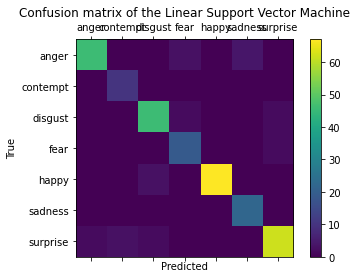

In [11]:
labels = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]
matriz = metrics.confusion_matrix(y_test, prediction, labels = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"])
print(matriz)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matriz)
if (type_of_model == 1):
    plt.title('Confusion matrix of the Linear Support Vector Machine')
elif (type_of_model == 2):
    plt.title('Confusion matrix of the Decision Tree')
elif (type_of_model == 3):
    plt.title('Confusion matrix of the KNN Classification')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
